<a href="https://colab.research.google.com/github/RichaCui70/Dynamics-between-Seafood-Fraudsters-and-Buyers/blob/main/Interactions_between_Buyers%2C_Fraudsters%2C_and_Seafood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <b>The nondimesionalized system</b>


## **Libraries, Parameters & Initial Values, and Equations as Functions**

Here, we introduce...

- The Python libraries used
- The initial parameter values
- The system as lambda equations (for calculations)
- The system as symbolic equations (for algebraic manipulations)
- Customized exceptions



In [56]:
# %pip install SALib

import os
import sys
import warnings
import random
import numbers
import pickle
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import mpl_toolkits.mplot3d as plt3d
from numpy.linalg import eig
from scipy.optimize import root, fsolve
# from SALib.analyze import sobol
# from SALib.sample.sobol import sample as sample
from matplotlib.patches import Patch
from ipywidgets import interact, FloatSlider
from skimage import measure
from scipy.spatial import cKDTree
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# import warnings
# warnings.filterwarnings("ignore")
# bump = 1e-9
bump = 0
seafood_state = lambda S, E, gamma_s: S * np.exp(gamma_s * (1 - S - E))
effort_state = lambda E, S, F, q, pw, c, e_sw, gamma_p, gamma_e: \
    E * np.exp(gamma_e * ((q * S * ((F*(pw - 1) + 1) / ((gamma_p * E * S + bump) ** e_sw))) - (F * (c - 1)) + 1))
def fraudster_state(S, E, F, Fp, gamma_f, gamma_m, gamma_p, pw, e_sw, e_sm, e_d):
    denom_market = (E * S)**(e_sm/2) + bump
    price_market = gamma_m * ((1 - Fp)**(e_d/2) / denom_market)
    
    denom_wholesale = (gamma_p * E * S)**(e_sw) + bump
    price_wholesale = (F * (pw - 1) + 1) / denom_wholesale
    
    delta = gamma_f * (price_market - price_wholesale)
    if bump != 0:
        delta = np.clip(delta, -20, 20) # Prevent overflow
    return (F * np.exp(delta)) / (1 + F * (np.exp(delta) - 1))
p_fraudster_state = lambda F, Fp, F_threshold: \
    (Fp * np.exp(F - F_threshold)) / (1 + Fp * (np.exp(F - F_threshold) - 1))

## **Helper Functions: Plotting the Model**

Here, we introduce helper functions to assist in plotting the system using matplotlib


In [3]:
def contour_plot(system=[], state_vars=[], init_vals=None, x_symbol=None, y_symbol=None, z_symbol=None, conditions={}, x_min=0, x_max=1, y_min=0, y_max=1, z_min=0, z_max=1, resolution=100, ax=None, **kwargs):
    '''
    Builds a contour plot based off the system and state variables provided, as well as the X and Y parameters to plot against.

    Args:
        system (list[sp.Expr], optional, defaults to []): List of Sympy expressions representing the system of equations
        state_vars (list[sp.Symbol], optional, defaults to []): List of Sympy symbols representing the state variables of the system
        init_vals (list[list[number.Numbers]], defaults to None): List of pair(s) of numbers representing the initial values of the state variables. Used if needed to numerically find the fixed points of the system. Should be the same order as its respective condition.
        x_symbol (sp.Symbol, defaults to None): Parameter to plot against the X axis
        y_symbol (sp.Symbol, defaults to None): Parameter to plot against the Y axis
        z_symbol (sp.Symbol, optional, defaults to None): Parameter to plot against the Z axis
        conditions (dict[str, dict[str, float]], optional, defaults to {}): Conditions/scenarios of the system (variables in the system that aren't being plotted against)
        x_min (float, optional, defaults to 0): Minimum x value to plot
        x_max (float, optional, defaults to 1): Maximum x value to plot
        y_min (float, optional, defaults to 0): Minimum y value to plot
        y_max (float, optional, defaults to 1): Maximum y value to plot
        z_min (float, optional, defaults to 0): Minimum z value to plot
        z_max (float, optional, defaults to 1): Maximum z value to plot
        resolution (int, optional, defaults to 100): Resolution of the contour plot (length of x and y vectors)
        ax (plt.Axes, optional, defaults to None): Matplotlib Axes to plot on
        **kwargs:
            condition_colors ((dict[str, dict[str, float]], optional, defaults to None):
            get_new_jacobian (bool, optional, defaults to True): Toggle to get new Jacobian matrix (usually done if you've changed the system)
            get_new_eg_vals (bool, optional, defaults to True): Toggle to get new eigenvalue gradient (usually done if you've changed any params above)
            jacobian_output_file_name (str, optional): Cache file's name for the Jacobian matrix. This is to either fetch the file or to save the file.
            eg_vals_output_file_name (str, optional): Cache file's name for the eigenvalue gradient. This is to either fetch the file or to save the file.
            filled (bool, optional, defaults to False): Toggle to fill the contour plot
            boundary_sensitivity (float, optional, defaults to 0.1): Set the tolerance for detecting stability boundaries in a 3D plot
    Returns:
        jac (sp.Matrix): The system's jacobian matrix
        eg_per_condition (dict[str, dict[str, str]]): The eigenvalue gradient for each condition
    '''
    def assign_random_colors(conditions, num_conditions):
        '''
        Helper function for contour_plot to assign random colors to conditions.
        '''
        cmap = plt.get_cmap('tab10')
        colors = [cmap(i % cmap.N) for i in range(num_conditions)]
        random.shuffle(colors)

        hex_colors = ['#%02x%02x%02x' % tuple(int(255 * c) for c in color[:3]) for color in colors]

        return dict(zip(conditions, hex_colors))
    class FixedPointSolver:
        def __init__(self, init_guess):
            """
            system_func: function(z, params) -> np.array, your system equations
            dim: dimension of the state space
            """
            self.init_guess = init_guess
            self.dim = np.shape(system)[0]
            self.cache = {}   # {(x,y): fixed_point}
            self.param_points = []  # list of (x,y)
            self.fixed_points = []  # list of fixed points
            self.kdtree = None
            self.counter = 0
        def _update_cache(self, params, fp):
            self.cache[tuple(params)] = fp
            self.param_points.append(params)
            self.fixed_points.append(fp)
            self.kdtree = cKDTree(self.param_points)

        def _guess_from_neighbors(self, params, k=3):
            if not self.param_points:
                return self.init_guess  # fallback seed
            if len(self.param_points) < k:
                k = len(self.param_points)
            dists, idxs = self.kdtree.query(params, k=k)
            if not hasattr(dists, '__iter__'):
                dists = np.array([dists])
            neighbor_fps = np.array([self.fixed_points[i] for i in np.atleast_1d(idxs)])
            # Weighted average guess (closer neighbors weigh more)
            weights = 1 / (dists + 1e-8)
            guess = np.average(neighbor_fps, axis=0, weights=weights)
            if self.counter < 5:
                print(f"Guess: {guess}, neighbours: {neighbor_fps}, params: {params}", file=sys.stderr)
                self.counter += 1
            # for i in guess:
            #     if i <= 0.01:
            #         print(f"Guess: {guess}, neighbours: {neighbor_fps}, params: {params}", file=sys.stderr)
            return guess
        def find_fixed_points(self, iter_params):
            guess = self._guess_from_neighbors(list(iter_params.values()))
            fixed_points = num_solve_system(system, state_vars, guess, params={**params, **iter_params})
            self._update_cache(tuple(iter_params.values()), list(fixed_points.values()))
            return fixed_points

    # Check if ax instance is of plt.Axes
    if z_symbol and not isinstance(ax, plt3d.Axes3D):
        raise Exception("ax must be a mpl_toolkits Axes3D object if using z_symbol")
    if isinstance(ax, plt.Axes) == False:
        raise Exception("ax must be a Matplotlib Axes object")

    # Check whether to load or solve for system's Jacobian
    jac = None
    numerically_solve = False
    jacobian_output_file_name = kwargs.get('jacobian_output_file_name', 'stability_jacobian.pickle')
    get_new_jacobian = kwargs.get('get_new_jacobian', True)

    # Load Jacobian of the system
    if get_new_jacobian == False:
        try:
            with open(f"{jacobian_output_file_name}", "rb") as f:
                print("Loading Jacobian...")
                jac, solved_fixed_points = pickle.load(f).values()
                if solved_fixed_points == False:
                    numerically_solve = True
                    print("Fixed points need to be numerically solved")
        except:
            print("Issue loading Jacobian")
            get_new_jacobian = True

    # Solve for Jacobian of the system
    if get_new_jacobian:
        with open(f"{jacobian_output_file_name}", "wb") as f:
            print("Solving Jacobian...")
            if not system:
                raise Exception("No system provided")
            if not state_vars:
                raise Exception("No state variables provided")
            jac, solved_fixed_points = get_jac(system, state_vars)
            if not solved_fixed_points:
                numerically_solve = True
                print("Fixed points need to be numerically solved")
            f.write(pickle.dumps({'jacobian': jac, 'solved_fixed_points': solved_fixed_points}))
            print(f"Jacobian cached in file '{os.getcwd()}/{jacobian_output_file_name}'")


    # Check whether to load or solve for eigenvalue gradients
    eg_per_condition = {}
    eg_vals_output_file_name = kwargs.get('eg_vals_output_file_name', 'eg_vals.pickle')
    get_new_eg_vals = kwargs.get('get_new_eg_vals', True)

    # Load eigenvalue gradients of the system
    if get_new_eg_vals == False:
        try:
            with open(f"{eg_vals_output_file_name}", "rb") as f:
                print("Loading eigenvalue gradient...")
                eg_per_condition = pickle.load(f)
        except:
            print("Issue loading eigenvalue gradient")
            eg_per_condition = {}
            get_new_eg_vals = True

    # Solve for eigenvalue gradients of the system
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    z_vals = None
    if z_symbol:
        z_vals = np.linspace(z_min, z_max, resolution)

    if get_new_eg_vals == True:
        if not x_symbol:
            raise Exception("No x symbol provided")
        if not y_symbol:
            raise Exception("No y symbol provided")
        if isinstance(conditions, dict) == False:
            raise Exception("Conditions must be a dictionary")
        if numerically_solve and (not hasattr(init_vals, '__iter__') or len(np.shape(init_vals)) != 2 or np.shape(init_vals)[1] != 2):
                raise Exception("init_vals must be list of pair(s) of numbers (ex. [[1, 2], ...])")

        num_conditions = len(conditions)
        if num_conditions != 0:
            # Assign colours per conditions
            condition_colors = kwargs.get('condition_colors', {})
            if len(condition_colors) != num_conditions:
                condition_colors = assign_random_colors(conditions, num_conditions)

            counter = 1
            for condition, params in conditions.items():
                print(f"Calculating eigenvalue gradient for condition: {condition} ({counter}/{num_conditions})")
                if z_symbol:
                    eigenvalue_magnitudes = np.zeros((resolution, resolution, resolution))
                else:
                    eigenvalue_magnitudes = np.zeros((resolution, resolution))

                solver = FixedPointSolver(init_guess=init_vals[counter-1])
                for i, x in enumerate(x_vals):
                    for j, y in enumerate(y_vals):
                        if z_symbol:
                            for k, z in enumerate(z_vals):
                                if numerically_solve:
                                    fixed_points = solver.find_fixed_points(iter_params={x_symbol: x, y_symbol: y, z_symbol: z})
                                eigenvalue_magnitudes[i, j, k] = eg_mod(params={**params, **fixed_points, x_symbol: x, y_symbol: y, z_symbol: z}, jac=jac)
                        else:
                            if numerically_solve:
                                fixed_points = solver.find_fixed_points(iter_params={x_symbol: x, y_symbol: y})
                                if i == 5 and j == 5:
                                    print({x_symbol: x, y_symbol: y})
                                    print(fixed_points)
                            eigenvalue_magnitudes[j, i] = eg_mod(params={**params, **fixed_points, x_symbol: x, y_symbol: y}, jac=jac)

                    if i % 10 == 0:
                        print(f"Progress: {i/len(x_vals)*100:.1f}%")
                eg_per_condition.update({condition: {'eigenvalue_magnitudes': eigenvalue_magnitudes, 'color': condition_colors[condition]}})
                counter += 1
            with open(f"{eg_vals_output_file_name}", "wb") as f:
                f.write(pickle.dumps(eg_per_condition))
                print(f"Eigenvalue gradient cached in file '{os.getcwd()}/{eg_vals_output_file_name}'")
        else:
            raise Exception("No conditions given")

    # Build contour plot
    legend_handles = []
    if z_symbol:
        for condition, val in eg_per_condition.items():
            if np.all(val['eigenvalue_magnitudes'] > 1):
                print(f"{condition} is always unstable under the conditions")
            elif np.all(val['eigenvalue_magnitudes'] < 1):
                print(f"{condition} is always stable under the conditions")
            else:
                boundary = np.where((np.abs(val['eigenvalue_magnitudes'] - 1) < kwargs.get('boundary_sensitivity', 0.1)).astype(int) == 1, 1, 0)
                verts, faces, normals, values = measure.marching_cubes(boundary, level=0.5)
                scale = [(x_vals.max()-x_vals.min())/(boundary.shape[0]-1),
                    (y_vals.max()-y_vals.min())/(boundary.shape[1]-1),
                    (z_vals.max()-z_vals.min())/(boundary.shape[2]-1)]
                offset = [x_vals.min(), y_vals.min(), z_vals.min()]

                verts = verts * scale + offset
                mesh = Poly3DCollection(verts[faces], alpha=0.4)
                mesh.set_facecolor(val['color'])
                ax.add_collection3d(mesh)

            legend_handles.append(Patch(facecolor=val['color'], edgecolor='black', label=condition, alpha=0.4))
    else:
        if kwargs.get('filled', True):
            for condition, val in eg_per_condition.items():
                ax.contourf(
                    x_vals,
                    y_vals,
                    val['eigenvalue_magnitudes'],
                    levels=[0, 1],
                    colors=[val['color']],
                    alpha=0.4
                )
                legend_handles.append(Patch(facecolor=val['color'], edgecolor='black', label=condition, alpha=0.4))
        else:
            for condition, val in eg_per_condition.items():
                ax.contour(
                    x_vals,
                    y_vals,
                    val['eigenvalue_magnitudes'],
                    levels=[1.0],
                    colors=[val['color']],
                    alpha=0.8
                )
                legend_handles.append(Patch(facecolor=val['color'], edgecolor='black', label=condition, alpha=0.4))

    ax.legend(handles=legend_handles)
    ax.set_xlabel(f'{x_symbol} parameter')
    ax.set_ylabel(f'{y_symbol} parameter')
    if z_symbol:
        ax.set_zlabel(f'{z_symbol} parameter')
    ax.set_title('Binary Stability Map')

    return jac, eg_per_condition

def line_graph(x_series, y_series, ax, **kwargs):
    """
    Creates a line graph in 2-D or 3-D (optional)

    Args:
        x_series (list[list[Number]]): Values along the x-axis.
        y_series (list[list[Number]]): Values along the y-axis. Same structure as `x_series`.
        ax (plt.Axes): Matplotlib Axes to build graph
        **kwargs: Additional keyword arguments containing graph metadata
            title (str): Title of the graph
            x_label (str): Label along x-axis
            y_label (str): Label along y-axis
            line_label (list[str]): Label(s) for the line(s)
            line_color (list[str]): Color(s) for the line(s)
            x_lim (tuple): The range of the x-axis
            y_lim (tuple): The range of the y-axis

    Returns:
        None
    """
    if not hasattr(x_series, '__iter__') or not hasattr(y_series, '__iter__'):
        raise Exception("x_series and y_series must be iterable")

    if len(x_series) != len(y_series) or len(x_series) == 0:
        raise Exception('x_series and y_series must not be empty')


    # Check if each element in the axis_series is an iterable
    if all(hasattr(a, '__iter__') for a in x_series) and all(hasattr(a, '__iter__') for a in y_series):
        # For each list within the axis_series, check if each element is a number
        if all(isinstance(a, numbers.Number) for sublist in x_series for a in sublist) and all(isinstance(a, numbers.Number) for sublist in y_series for a in sublist):
            # For each list within the axis_series, check if each the list matches the size of the list in the other axis_series
            if all(len(a) == len(b) for a, b in zip(x_series, y_series)):
                line_label_exists = 'line_label' in kwargs and len(kwargs['line_label']) == len(x_series) and all(isinstance(a, str) for a in kwargs['line_label'])
                line_color_exists = 'line_color' in kwargs and len(kwargs['line_color']) == len(x_series) and all(isinstance(a, str) for a in kwargs['line_color'])
                for i in range(len(x_series)):
                    ax.plot(
                    x_series[i],
                    y_series[i],
                    label=kwargs['line_label'][i]
                        if line_label_exists else None,
                    color=kwargs['line_color'][i]
                        if line_color_exists else None,
                    )
                    if line_label_exists:
                        ax.legend()
            else:
                raise Exception("x_series shape does not match y_series")
        else:
            raise Exception("Series elements aren't series of numbers")

    else:
        raise Exception("Series elements aren't iterable")

    if 'title' in kwargs:
      ax.set_title(kwargs['title'])
    if 'x_label' in kwargs:
      ax.set_xlabel(kwargs['x_label'])
    if 'y_label' in kwargs:
      ax.set_ylabel(kwargs['y_label'])
    if 'x_lim' in kwargs:
      ax.set_xlim(kwargs['x_lim'])
    if 'y_lim' in kwargs:
      ax.set_ylim(kwargs['y_lim'])

    ax.grid(True)

def phase_portrait(x_series, y_series, ax, **kwargs):
    """
    Creates a line graph in 2-D or 3-D (optional)

    Args:
        x_series (list[Number]): Values along the x-axis.
        y_series (list[Number]): Values along the y-axis. Same structure as `x_series`.
        ax (plt.Axes): Matplotlib Axes to build graph
        **kwargs: Additional keyword arguments containing graph metadata
            title (str): Title of the graph
            x_label (str): Label along x-axis
            y_label (str): Label along y-axis
            line_label (list[str]): Label(s) for the line(s)
            line_color (list[str]): Color(s) for the line(s)
            x_lim (tuple): The range of the x-axis
            y_lim (tuple): The range of the y-axis

    Returns:
        None
    """
    if not hasattr(x_series, '__iter__') or not hasattr(y_series, '__iter__'):
        raise Exception("x_series and y_series must be iterable")

    if len(x_series) != len(y_series) or len(x_series) == 0:
        raise Exception('x_series and y_series must not be empty')

    if not all(isinstance(a, numbers.Number) for a in x_series) or not all(isinstance(a, numbers.Number) for a in y_series):
        raise Exception('x_series and y_series must be series of numbers')


    line_label_exists = 'line_label' in kwargs and len(kwargs['line_label']) == len(x_series) and all(isinstance(a, str) for a in kwargs['line_label'])
    line_color_exists = 'line_color' in kwargs and len(kwargs['line_color']) == len(x_series) and all(isinstance(a, str) for a in kwargs['line_color'])
    ax.plot(
    x_series,
    y_series,
    label=kwargs['line_label'][i]
        if line_label_exists else None,
    color=kwargs['line_color'][i]
        if line_color_exists else None,
    )
    if line_label_exists:
        ax.legend()

    if 'title' in kwargs:
      ax.set_title(kwargs['title'])
    if 'x_label' in kwargs:
      ax.set_xlabel(kwargs['x_label'])
    if 'y_label' in kwargs:
      ax.set_ylabel(kwargs['y_label'])
    if 'x_lim' in kwargs:
      ax.set_xlim(kwargs['x_lim'])
    if 'y_lim' in kwargs:
      ax.set_ylim(kwargs['y_lim'])

    ax.grid(True)

def sobol_bar_chart(ax, indices=[], values=[], x_tick_labels=[], bar_labels=[], **kwargs):
    """
    Creates a bar chart to display Sobol Indices

    Args:
        ax (plt.Axes): Matplotlib Axes to build graph
        indices (list[list[Number]], optional, defaults to []): Position of the bars along the x-axis.
        values (list[list[Number]], optional, defaults to []): Values along the y-axis
        x_tick_labels (list[str], optional, defaults to []): Labels for each parameter
        bar_labels (list[str], optional, defaults to []): Labels for each categories of bars
        **kwargs: Additional keyword arguments containing chart metadata
            title (str): Title of the graph
            x_label (str): Label along x-axis
            y_label (str): Label along y-axis
            bar_width (list[Number]): Width of the bars

    Returns:
        None
    """
    if not isinstance(ax, plt.Axes):
        raise WrongType("ax must be a Matplotlib Axes object")

    if not hasattr(indices, '__iter__') or not hasattr(values, '__iter__') or not hasattr(x_tick_labels, '__iter__') or not hasattr(bar_labels, '__iter__'):
        raise WrongType("indices, values, x_tick_labels, bar_labels must be iterable")
    if np.shape(indices) != np.shape(values):
        raise WrongSize("indices doesn't match the shape of values")
    if len(bar_labels) != np.shape(values)[0]:
        raise WrongSize("Number of bar_labels don't match the number of categories")
    if len(x_tick_labels) != np.shape(values)[1]:
        raise WrongSize("Number of x_tick_labels don't match the number of parameters")

    bar_width = kwargs.get("bar_width", 0.35)
    if not isinstance(bar_width, numbers.Number):
        warnings.warn("bar_width should be a number ~ assigned as 0.35 now", category=RuntimeWarning)
        bar_width = 0.35


    for i in range(len(values)):
        ax.bar(indices[i], values[i], bar_width, label=bar_labels[i])


    ax.set_xticks(indices[0] + ((bar_width * (np.shape(values)[0]-1)) / 2))
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel(kwargs.get("x_label", ""))
    ax.set_ylabel(kwargs.get("y_label", ""))
    ax.set_title(kwargs.get("title", ""))
    ax.legend()

def surface_plot(x_series, y_series, z_series, ax, **kwargs):
    """
    Creates a line graph in 2-D or 3-D (optional)

    Args:
        x_series (list[list[list[Number]]]): Values along the x-axis.
        y_series (list[list[list[Number]]]): Values along the y-axis. Same structure as `x_series`.
        z_series (list[list[list[Number]]]): Values along the z-axis. Same structure as `x_series`.
        ax (plt.Axes): Matplotlib Axes to build graph. Should have 3D projection.
        **kwargs: Additional keyword arguments containing graph metadata
            title (str): Title of the graph
            x-label (str): Label along x-axis
            y_label (str): Label along y-axis
            z_label (str): Label along z-axis
            surface_label (list[str]): Label(s) for the surface(s)
            surface_color (list[str]): Color(s) for the surface(s)
            x_lim (tuple): The range of the x-axis
            y_lim (tuple): The range of the y-axis
            z_lim (tuple): The range of the z-axis
            view (tuple): The view of the plot
    Returns:
        None
    """
    if isinstance(ax, plt.Axes) == False:
        raise Exception("ax must be a Matplotlib Axes object")

    if not hasattr(x_series, '__iter__') or not hasattr(y_series, '__iter__') or not hasattr(z_series, '__iter__'):
        raise Exception("x_series, y_series, and z_series must be iterable")

    if not (len(x_series) == len(y_series) == len(z_series) and len(z_series) != 0):
        raise Exception('x_series and y_series must not be empty')

    def is_3d_list_of_numbers(x):
        for sub1 in x:
            if not hasattr(sub1, '__iter__'):
                return False
            for sub2 in sub1:
                if not hasattr(sub2, '__iter__'):
                    return False
                if not all(isinstance(item, numbers.Number) for item in sub2):
                    return False
        return True

    # Check if each element in the axis_series is an iterable
    if all(hasattr(a, '__iter__') for a in x_series) and all(hasattr(a, '__iter__') for a in y_series) and all(hasattr(a, '__iter__') for a in z_series):
        # For each list within the axis_series, check if each element is a number
        if is_3d_list_of_numbers(x_series) and is_3d_list_of_numbers(y_series) and is_3d_list_of_numbers(z_series):
            # For each list within the axis_series, check if each the list matches the size of the list in the other axis_series
            if np.shape(x_series) == np.shape(y_series) == np.shape(z_series):
                surface_label_exists = 'surface_label' in kwargs and len(kwargs['surface_label']) == len(x_series) and all(isinstance(a, str) for a in kwargs['surface_label'])
                for i in range(len(x_series)):
                    ax.plot_surface(
                    x_series[i],
                    y_series[i],
                    z_series[i],
                    alpha=0.5,
                    edgecolor='none',
                    linewidth=0.5,
                    label=kwargs['surface_label'][i]
                        if surface_label_exists else None,
                    color=kwargs['surface_color'][i]
                        if 'surface_color' in kwargs and len(kwargs['surface_color']) == len(x_series) and all(isinstance(a, str) for a in kwargs['surface_color']) else None,
                    )
                    if surface_label_exists:
                        ax.legend()
            else:
                raise Exception("The series' shapes don't match one another")
        else:
            raise Exception("Surfaces aren't series of numbers")
    else:
        raise Exception("Series elements aren't iterable")

    if 'title' in kwargs:
      ax.set_title(kwargs['title'])
    if 'x_label' in kwargs:
      ax.set_xlabel(kwargs['x_label'])
    if 'y_label' in kwargs:
      ax.set_ylabel(kwargs['y_label'])
    if 'z_label' in kwargs:
      ax.set_zlabel(kwargs['z_label'])
    if 'x_lim' in kwargs:
      ax.set_xlim(kwargs['x_lim'])
    if 'y_lim' in kwargs:
      ax.set_ylim(kwargs['y_lim'])
    if 'z_lim' in kwargs:
      ax.set_zlim(kwargs['z_lim'])
    if 'view' in kwargs and len(np.shape(kwargs['view'])) > 0 and np.shape(kwargs['view'])[0] == 3:
        ax.view_init(kwargs['view'][0], kwargs['view'][1], kwargs['view'][2])

    ax.grid(True)

## **Time Series**


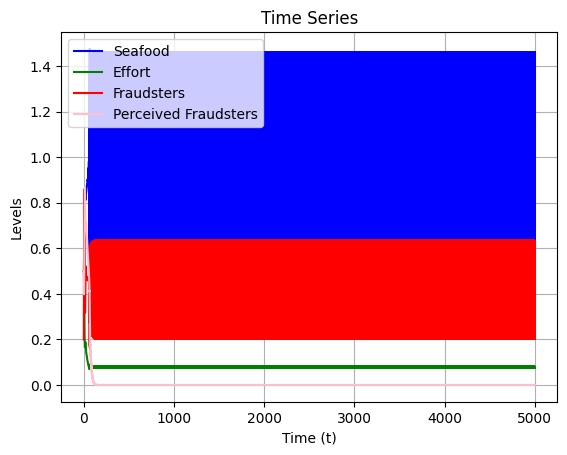

In [58]:
def system_map(state, params):
    S, E, F, FP = state
    # Unpack parameters dictionary for clarity
    gamma_m = params['gamma_m']
    gamma_f = params['gamma_f']
    gamma_s = params['gamma_s']
    gamma_e = params['gamma_e']
    gamma_p = params['gamma_p']
    e_sm = params['e_sm']
    e_sw = params['e_sw']
    e_d = params['e_d']
    q = params['q']
    pw = params['pw']
    c = params['c']
    F_threshold = params['F_threshold']
    
    # Calculate next steps
    S_new = seafood_state(S, E, gamma_s)
    E_new = effort_state(E, S, F, q, pw, c, e_sw, gamma_p, gamma_e)
    F_new = fraudster_state(S, E, F, FP, gamma_f, gamma_m, gamma_p, pw, e_sw, e_sm, e_d)
    Fp_new = p_fraudster_state(F, FP, F_threshold)
    return np.array([S_new, E_new, F_new, Fp_new])

# Find fixed points
# Function to zero-out (Map(x) - x = 0)
def residuals(state, params):
    return system_map(state, params) - state

# A simple finite difference function to get Jacobian if you don't want external libs
def get_jacobian_numerical(func, state, params, epsilon=1e-7):
    n = len(state)
    J = np.zeros((n, n))
    f0 = func(state, params)
    
    for i in range(n):
        perturb = np.zeros(n)
        perturb[i] = epsilon
        f_perturb = func(state + perturb, params)
        J[:, i] = (f_perturb - f0) / epsilon
        
    return J

# Old parameters that are still relevant in the nondimensionalized system
old_params = {
    'q': 0.0002,
    'r': 0.02,
    'K': 1.0,
    'Pw1': 5,
    'Pw0': 1,
    'C1': 2,
    'C0': 1,
    'e_sm': 1.0,
}
# Nondimensionalized parameters
new_params = {
    'gamma_m': 1.0 / (old_params['Pw0'] * (old_params['r'] * old_params['K']) ** (old_params['e_sm'] / 2)), # gamma_m / (Pw0 * (r * K)^(e_sm / 2)...
    'gamma_f': 110 * old_params['Pw0'],                         # gamma_f * Pw0
    'gamma_s': 1.0 * old_params['r'],                           # gamma_s * r
    'gamma_e': 0.6 * old_params['C0'],                          # gamma_e * C0
    'gamma_p': 5000.0 * old_params['r'] * old_params['K'],         # gamma_s * r * K
    'e_sm': 1.0,
    'e_sw': 1.0,
    'e_d': 1.0,
    'F_threshold': 0.5,
    'q': (old_params['q'] * old_params['Pw0'] * old_params['K']) / old_params['C0'],        # (q * Pw0 * K) / C0
    'pw': old_params['Pw1']/old_params['Pw0'],                                              # Pw1/Pw0
    'c': old_params['C1']/old_params['C0'],                     # C1/C0
}
# Nondimensionalized parameters without worrying about their definitions
new_params_without_old_influence = {
    'gamma_m': 1.0, 
    'gamma_f': 1.0, 
    'gamma_s': 2.5,
    'gamma_e': 0.15,
    'gamma_p': 15.0,
    'e_sm': 1.0, 
    'e_sw': 1.0,
    'e_d': 1.0, 
    'F_threshold': 0.5, 
    'q': 0.02,
    'pw': 5.0,
    'c': 3.5
}
# Initial starting values 
init_vals = [0.5, 0.5, 0.2, 0.5]
def time_series(params, initial_vals, time=5000):
    seafood, effort, fraudsters, p_fraudsters = np.array([initial_vals[0]], dtype=np.longdouble), np.array([initial_vals[1]], dtype=np.longdouble), np.array([initial_vals[2]], dtype=np.longdouble), np.array([initial_vals[3]], dtype=np.longdouble)
    time_period = []
    for i in range(time):
        time_period.append(i)
        seafood = np.append(seafood, seafood_state(seafood[i], effort[i], params['gamma_s']))
        effort = np.append(effort, effort_state(effort[i], seafood[i], fraudsters[i], params['q'], params['pw'], params['c'], params['e_sw'], params['gamma_p'], params['gamma_e']))
        fraudsters = np.append(fraudsters, fraudster_state(seafood[i], effort[i], fraudsters[i], p_fraudsters[i], params['gamma_f'], params['gamma_m'], params['gamma_p'], params['pw'], params['e_sw'], params['e_sm'], params['e_d']))
        p_fraudsters = np.append(p_fraudsters, p_fraudster_state(fraudsters[i], p_fraudsters[i], params['F_threshold']))
    time_period.append(time)
            
    fig, axs = plt.subplots(1, 1)
    # axs.set_ylim(0, 1.3)
    line_graph([time_period, time_period, time_period, time_period], [seafood, effort, fraudsters, p_fraudsters], axs, title=f"Time Series", y_label="Levels", x_label="Time (t)", line_label=["Seafood", "Effort", "Fraudsters", "Perceived Fraudsters"], line_color=["Blue", "green", "red", "pink"])
    plt.show()





# Solve
# sol = root(residuals, init_vals, args=(new_params_without_old_influence), method='hybr')

# if sol.success:
#     S_star, E_star, F_star, FP_star = sol.x
#     print(f"\nFixed Point found: S={S_star:.4f}, E={E_star:.4f}, F={F_star:.4f}, Fp={FP_star:.4f}")
# else:
#     print(f"\nSolver failed: {sol.message}")

time_series(new_params_without_old_influence, init_vals)

## **Bifurcation Diagram**

Generating Bifurcation Diagram for gamma_s...


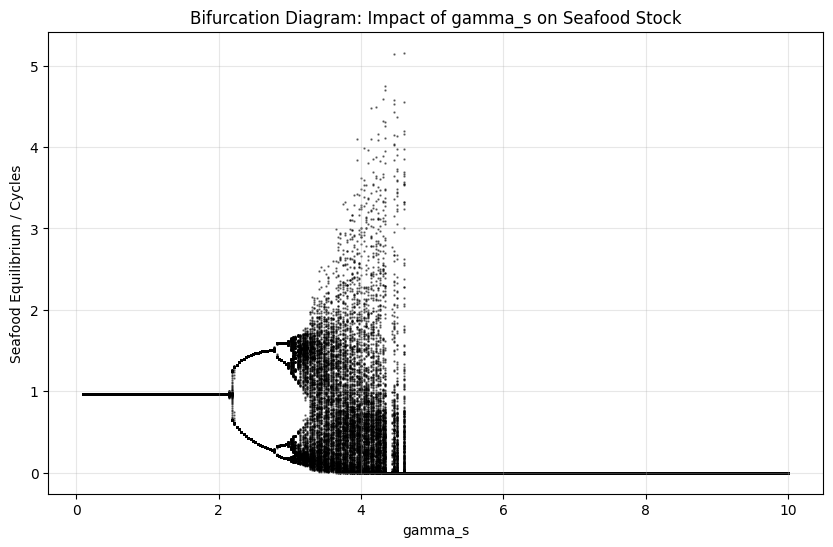

In [48]:
def run_system(params, steps=500, transient=200):
    # Initial starting points
    S, E, F, FP = 0.5, 0.5, 0.2, 0.5
    
    trajectory = []
    
    for t in range(steps):
        # Update
        S_new = seafood_state(S, E, params['gamma_s'])
        E_new = effort_state(E, S, F, params['q'], params['pw'], params['c'], 
                             params['e_sw'], params['gamma_p'], params['gamma_e'])
        F_new = fraudster_state(S, E, F, FP, params['gamma_f'], params['gamma_m'], 
                                params['gamma_p'], params['pw'], params['e_sw'], 
                                params['e_sm'], params['e_d'])
        FP_new = p_fraudster_state(F, FP, params['F_threshold'])
        
        # Safety Clip
        S, E, F, FP = np.maximum([S_new, E_new, F_new, FP_new], 1e-6)
        
        # Store only after transient period to see steady state behavior
        if t > transient:
            trajectory.append(S) # We track Seafood for the diagram
            
    return trajectory

# --- Bifurcation Analysis ---

base_params = {
    'gamma_m': 1.0,
    'gamma_f': 1.0,
    # 'gamma_s': 3.2,
    'gamma_e': 0.15,
    'gamma_p': 15.0,
    'e_sw': 1.0,
    'e_sm': 1.0,
    'e_d': 1.0,
    'F_threshold': 0.5,
    'q': 0.02,
    'pw': 5.0,
    'c': 3.5
}

# Variable to Sweep: 'gamma_s' (Seafood Growth Rate) is the classic chaos trigger
param_name = 'gamma_s'
param_values = np.linspace(0.1, 10.0, 300) # Sweep from stable to chaotic

x_vals = []
y_vals = []

print(f"Generating Bifurcation Diagram for {param_name}...")

for val in param_values:
    # Update param
    current_params = base_params.copy()
    current_params[param_name] = val
    
    # Run
    points = run_system(current_params)
    
    # Append to lists
    for p in points:
        x_vals.append(val)
        y_vals.append(p)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, s=0.5, c='black', alpha=0.5)
plt.title(f'Bifurcation Diagram: Impact of {param_name} on Seafood Stock')
plt.xlabel(param_name)
plt.ylabel('Seafood Equilibrium / Cycles')
plt.grid(True, alpha=0.3)
plt.show()